# Preparation

In [1]:
# Import of basic libraries for converting data from excel to a dataframe and libraries that provide functions to plot the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

from sklearn.preprocessing import LabelEncoder, StandardScaler

# TQDM provides progressbars
from tqdm import tqdm

# We some of the standard classifiers.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Import a set of standard classification metrics
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, confusion_matrix

# We also import the functions for the cross-validation
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_validate, cross_val_predict





In [2]:
# Import dataset
path ="https://github.com/KingKai69/VisualAnalytics/raw/main/Automobile_data.csv"
df = pd.read_csv(path)
df.rename(columns={'symboling': 'risk-score'}, inplace=True)
df.head()

,risk-score,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [3]:
#df.describe()

# Data Preprocessing

In [4]:
# Show the columns that contain nan
#df.isna().any()

In [5]:
# Interpolation of NaN Values
# Replace "?" with NaN
df.replace('?', float('nan'), inplace=True)
# Replace NaN values with mode of respective column
df_imp = df.fillna(df.mode().iloc[0])
df_imp.isna().any()

risk-score           False
normalized-losses    False
make                 False
fuel-type            False
aspiration           False
num-of-doors         False
body-style           False
drive-wheels         False
engine-location      False
wheel-base           False
length               False
width                False
height               False
curb-weight          False
engine-type          False
num-of-cylinders     False
engine-size          False
fuel-system          False
bore                 False
stroke               False
compression-ratio    False
horsepower           False
peak-rpm             False
city-mpg             False
highway-mpg          False
price                False
dtype: bool

In [6]:
#df_imp.head()

## Label Encoding

In [7]:
# Evtl. alle Spalten codieren?

# Init new LabelEncoder Object
le = LabelEncoder()

# Init dataframe for encoded data
df_enc = df_imp.copy()

# Wenden Sie den LabelEncoder auf mehrere Spalten in Ihrem DataFrame an
columns_to_encode = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location','engine-type','num-of-cylinders','fuel-system']  # Liste mit den Spaltennamen
for column in columns_to_encode:
    df_enc[column] = le.fit_transform(df_enc[column])

df_enc.head()

,risk-score,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,161,0,1,0,1,0,2,0,88.6,...,130,5,3.47,2.68,9.0,111,5000,21,27,13495
1,3,161,0,1,0,1,0,2,0,88.6,...,130,5,3.47,2.68,9.0,111,5000,21,27,16500
2,1,161,0,1,0,1,2,2,0,94.5,...,152,5,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,1,1,0,0,3,1,0,99.8,...,109,5,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,1,1,0,0,3,0,0,99.4,...,136,5,3.19,3.4,8.0,115,5500,18,22,17450


In [8]:
# Changes dtypes of respective column from object to int64 respective float 64, important for XAI SHAP
for col in df_enc.columns:
    if df_enc[col].dtype == 'object':
        try:
            df_enc[col] = df_enc[col].astype('int64')
        except ValueError:
            try:
                df_enc[col] = df_enc[col].astype('float64')
            except ValueError:
                pass  # Wenn die Spalte nicht konvertiert werden kann, überspringen wir sie einfach

print(df_enc.dtypes)

risk-score             int64
normalized-losses      int64
make                   int64
fuel-type              int64
aspiration             int64
num-of-doors           int64
body-style             int64
drive-wheels           int64
engine-location        int64
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type            int64
num-of-cylinders       int64
engine-size            int64
fuel-system            int64
bore                 float64
stroke               float64
compression-ratio    float64
horsepower             int64
peak-rpm               int64
city-mpg               int64
highway-mpg            int64
price                  int64
dtype: object


## Scaling

In [9]:
df_features = df_enc.drop(['risk-score'], axis=1)

# Init new Scaler
scaler = StandardScaler()

# Fit Scaler
scaled_data = scaler.fit_transform(df_features)

df_sc = pd.DataFrame(scaled_data, columns=df_features.columns)

df_sc['risk-score'] = df_enc['risk-score']

In [10]:
# Check for imbalance
pd.value_counts(df_imp['risk-score'])

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: risk-score, dtype: int64

In [11]:
# Create 3 label Classification
df_enc_3 = df_enc.copy()
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(3, 'high-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(2, 'high-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(1, 'medium-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(0, 'medium-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(-1, 'low-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(-2, 'low-risk')
pd.value_counts(df_enc_3['risk-score'])

medium-risk    121
high-risk       59
low-risk        25
Name: risk-score, dtype: int64

In [12]:
# Create list of all possible features (25)
features = [
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price',
]

<Axes: >

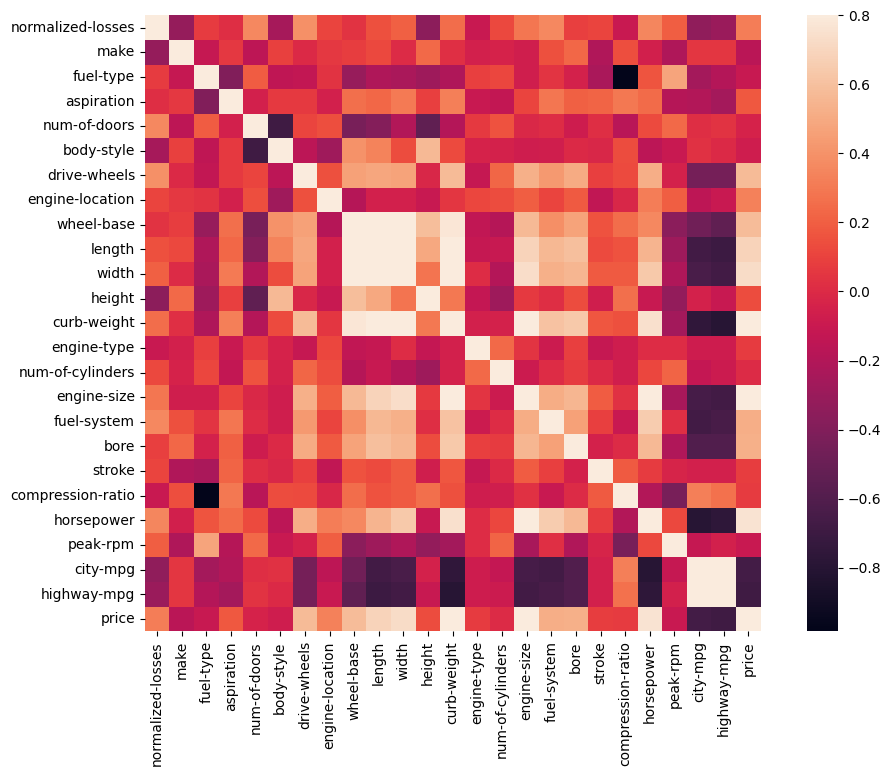

In [13]:
# Create Correlation matrix
Val = df_enc_3[features]
corrmat = Val.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat, vmax=.8, square=True)

#print(corr_df)

In [14]:
# Create df with high correlated feature pairs
corrmat_masked = corrmat.mask(abs(corrmat) >= 1)

# Filtern der Korrelationen über 0,5 und unter -0,5
high_corr = corrmat_masked[(corrmat_masked > 0.7) | (corrmat_masked < -0.7)].stack().reset_index()
high_corr.columns = ['Feature_A', 'Feature_B', 'Correlation']

# Entfernen von Duplikaten
high_corr = high_corr[high_corr['Feature_A'] < high_corr['Feature_B']]

high_corr.head(n=120)

,Feature_A,Feature_B,Correlation
2,wheel-base,width,0.795144
4,length,wheel-base,0.874587
5,length,width,0.841118
13,curb-weight,wheel-base,0.776386
14,curb-weight,length,0.877728
15,curb-weight,width,0.867032
16,curb-weight,engine-size,0.850594
17,curb-weight,horsepower,0.748539
19,curb-weight,highway-mpg,-0.797465
20,curb-weight,price,0.820807


# Modelling

In [62]:
# Create list of features
features_nonCor = [
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    #'wheel-base',
    #'length',
    #'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    #'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    #'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    #'highway-mpg',
    #'price',
]

In [16]:
# Fixing the SEED
SEED = 27

In [63]:
# Define X and Y Data
x_data = df_enc_3[features_nonCor]
y_data = df_enc_3['risk-score']

x_data_s = df_sc[features_nonCor]
y_data_s = df_sc['risk-score']

In [64]:
# Train Test Split for non scaled data
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=SEED, stratify=y_data)

# Train Test for scaled data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_data_s, y_data_s, test_size=0.25, random_state=SEED, stratify=y_data_s)

In [19]:
# Check distribution of test labels

labels = ['high-risk', 'medium-risk', 'low-risk']

# Initialisiere Zähler für jeden Begriff
zaehler = {label: 0 for label in labels}

# Zähle das Vorkommen der Begriffe in der Liste
for element in y_test:
    if element in zaehler:
        zaehler[element] += 1

# Ergebnis ausgeben
for begriff, anzahl in zaehler.items():
    anteil = anzahl / len(y_test)
    print(f"Der Begriff '{begriff}' kommt {anzahl} mal vor. Anteil: {anteil:.2%}")

Der Begriff 'high-risk' kommt 15 mal vor. Anteil: 28.85%
Der Begriff 'medium-risk' kommt 31 mal vor. Anteil: 59.62%
Der Begriff 'low-risk' kommt 6 mal vor. Anteil: 11.54%


In [20]:
# KFold Train / Validation Split
kf_cv = KFold(n_splits = 5, shuffle = True, random_state=SEED)

# Spot Checking

In [21]:
# Definitions of metric
scorings = {
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=1), 
    'mcc': make_scorer(matthews_corrcoef),
    }

In [47]:
# Definition of models for spot checking
def get_models():
    models=[
       ('Decision Tree',DecisionTreeClassifier(random_state = SEED)),
       ('Random Forest',RandomForestClassifier(random_state = SEED)),
       ('Extremely Randomized Trees',ExtraTreesClassifier(random_state = SEED)),
       ('Ada Boost',AdaBoostClassifier(random_state = SEED)),
       ('Gradient Boosting',GradientBoostingClassifier(random_state = SEED)),
       ('Support Vector Machine', SVC()),   
       ('Naive Bayes', GaussianNB()),    
       ('KNN', KNeighborsClassifier()),    
       ('Support Vector Machine', SVC()),
       ('Multilayer Perceptron',MLPClassifier(max_iter = 1000, random_state = SEED)),
    ]
    return models

In [65]:
# Get our set of different models for the spot checking
models = get_models()

# Empty list to print the results as a nice table
all_cv_scores = []

# We will iter through our list of models
# We will perform the full cross validate run using the current model
for name, clf in tqdm(models):
    
    # We want to improve the printing of our results
    # Therefore we add all the values into a dictionary which we will format for later printing using Pandas 
    formatted_result = {}
    formatted_result['Classifier'] = name

    # Use the simple cross_validate wrapper greatly simplifies the spot checking. We will just compare the models using our 
    cv_score  = cross_validate(estimator = clf, X = X_train, y = y_train, cv = kf_cv, scoring = scorings)

    # cv scores contains the arrays with the score for the current scoring function
    # We will calculate the mean and std and add them to the formatted result dictionary
    for score_name, scores in cv_score.items():
        # Add the completely prepared string 
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)
        
        #formatted_result[f'{score_name}'] = scores # We could also add the raw data to the dataframe. However this will make is less readable

    # We need to add the final rows of our results to an overall list.
    # This simplifies the creation of the dataframe
    all_cv_scores.append(formatted_result)

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


In [66]:
pd.DataFrame(all_cv_scores)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std
0,Decision Tree,0.003579,0.001449,0.003731,0.000251,0.789869,0.072955,0.642869,0.093273
1,Random Forest,0.153904,0.003741,0.014442,0.001799,0.870496,0.080793,0.761963,0.146558
2,Extremely Randomized Trees,0.114974,0.001820,0.014721,0.000902,0.865364,0.108655,0.767872,0.171990
3,Ada Boost,0.085488,0.003185,0.011458,0.000488,0.663277,0.098949,0.407303,0.172460
4,Gradient Boosting,0.339985,0.010197,0.005148,0.000495,0.839788,0.111970,0.718026,0.181241
5,Support Vector Machine,0.003532,0.000266,0.004036,0.000020,0.438752,0.095483,0.000000,0.000000
6,Naive Bayes,0.002428,0.000054,0.003806,0.000087,0.646885,0.055324,0.416781,0.054555
7,KNN,0.002242,0.000117,0.006231,0.000218,0.633144,0.104011,0.339174,0.195865
8,Support Vector Machine,0.003833,0.000759,0.004057,0.000293,0.438752,0.095483,0.000000,0.000000
9,Multilayer Perceptron,0.020066,0.002925,0.004855,0.000671,0.420512,0.091785,0.099544,0.074527


In [67]:
# SPOT Checking with Scaling

# Get our set of different models for the spot checking
models = get_models()

# Empty list to print the results as a nice table
all_cv_scores_s = []

# We will iter through our list of models
# We will perform the full cross validate run using the current model
for name, clf in tqdm(models):
    
    # We want to improve the printing of our results
    # Therefore we add all the values into a dictionary which we will format for later printing using Pandas 
    formatted_result = {}
    formatted_result['Classifier'] = name

    # Use the simple cross_validate wrapper greatly simplifies the spot checking. We will just compare the models using our 
    cv_score  = cross_validate(estimator = clf, X = x_data_s, y = y_data_s, cv = kf_cv, scoring = scorings)

    # cv scores contains the arrays with the score for the current scoring function
    # We will calculate the mean and std and add them to the formatted result dictionary
    for score_name, scores in cv_score.items():
        # Add the completely prepared string 
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)
        
        #formatted_result[f'{score_name}'] = scores # We could also add the raw data to the dataframe. However this will make is less readable

    # We need to add the final rows of our results to an overall list.
    # This simplifies the creation of the dataframe
    all_cv_scores_s.append(formatted_result)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


In [68]:
pd.DataFrame(all_cv_scores_s)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std
0,Decision Tree,0.006387,0.001983,0.007640,0.000546,0.730214,0.062094,0.648923,0.086798
1,Random Forest,0.203333,0.052992,0.016476,0.003280,0.761489,0.037946,0.693468,0.055041
2,Extremely Randomized Trees,0.124767,0.004072,0.016415,0.001566,0.785991,0.056933,0.724595,0.068262
3,Ada Boost,0.090620,0.003245,0.014626,0.002334,0.437957,0.072186,0.319087,0.062481
4,Gradient Boosting,0.709991,0.056838,0.005324,0.000137,0.765999,0.041642,0.696133,0.050764
5,Support Vector Machine,0.005114,0.001302,0.004879,0.001138,0.676969,0.067062,0.594367,0.072343
6,Naive Bayes,0.002424,0.000062,0.004216,0.000402,0.370759,0.077938,0.352419,0.064948
7,KNN,0.002017,0.000139,0.006800,0.000301,0.595001,0.045552,0.479897,0.065941
8,Support Vector Machine,0.004642,0.000547,0.004357,0.000449,0.676969,0.067062,0.594367,0.072343
9,Multilayer Perceptron,1.174364,0.345161,0.007134,0.001802,0.722104,0.065038,0.633204,0.073030


# Hyperparametertuning

In [74]:
#Init best model for hyperparametertuning
model = RandomForestClassifier(class_weight='balanced', random_state = SEED)

# define parameter space
param_dist = {
              'n_estimators': randint(50, 500),
              "criterion": ["gini", "entropy", 'log_loss'],
              "max_depth": randint(1, 21),
              "min_samples_split": randint(1, 20),
              "min_samples_leaf": randint(1, 20),
              "max_features": ["sqrt", "log2", None], 
              "bootstrap": [True, False],
              }

# Init optimizer
hyperparam_optimizer = RandomizedSearchCV(estimator = model, # The estimator or pipeline we want to optimize
                                          param_distributions = param_dist, # Our parameter grid
                                          n_iter = 25, # Searches for 10 random combinations
                                          n_jobs = -1, # Use all available CPU cores
                                          scoring = "f1_weighted", # Name of the scorer used for 
                                          cv = kf_cv # The CrossValidation to use
                                          )

In [75]:
# fit the randomized search object to the training data
hyperparam_optimizer.fit(X_train, y_train)

# print best parameters and score
print("Best parameters found: ", hyperparam_optimizer.best_params_)
print("Best F1 score found: ", hyperparam_optimizer.best_score_)

Best parameters found:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 173}
Best F1 score found:  0.8218264851291341


# Final Evaluation 5 Fold cross validated (seen data)

In [ ]:
# Init new classifier with best setting of Hyperparameters
#clf_final = RandomForestClassifier(n_estimators=301, criterion="gini", max_depth=12 , max_features='sqrt', bootstrap=False, class_weight='balanced', random_state = SEED)
clf_final = RandomForestClassifier(n_estimators=173, criterion="gini", max_depth=12, min_samples_split=5, min_samples_leaf=1, max_features='log2', bootstrap=True, class_weight='balanced', random_state = SEED)

scoring = {'f1_score': make_scorer(f1_score, average='weighted', zero_division=1)}

cv_final = cross_validate(estimator = clf_final, X = X_train, y = y_train, cv = kf_cv, scoring = scoring)

f1_scores = cv_final['test_f1_score']

# Durchschnittlichen F1-Score berechnen
mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

# Confusion-Matrix berechnen
y_pred_cv = cross_val_predict(clf_final, X_train, y_train, cv=kf_cv)
cm_cv = confusion_matrix(y_train, y_pred_cv)

# Ergebnisse ausgeben
print("Durchschnittlicher F1-Score: {:.2f}".format(mean_f1_score))
print("Standardabweichung des F1-Scores: {:.2f}".format(std_f1_score))


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv, annot=True, cmap='Blues', fmt='d', xticklabels=['high-risk','low-risk','medium-risk'], yticklabels=['high-risk','low-risk','medium-risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Final Evaluation of unseen test data

In [77]:
# Fit the model
clf_final.fit(X_train, y_train)

# Create predictions
y_pred_final = clf_final.predict(X_test)

# Calculate F1score
f1_final = f1_score(y_test, y_pred_final, average='weighted', zero_division=1)
print("F1-Score: {:.2f}".format(f1_final))

F1-Score: 0.90


Text(70.72222222222221, 0.5, 'Actual')

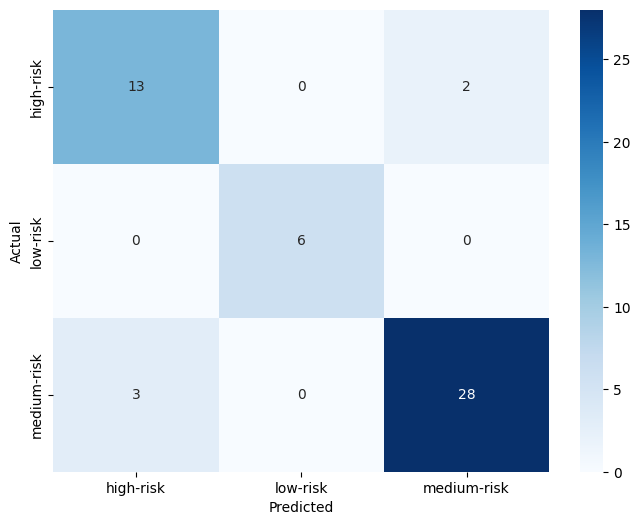

In [78]:
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=clf_final.classes_, yticklabels=clf_final.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Explainable AI

In [79]:
df_results = pd.DataFrame({'Test Labels': y_test, 'Predicted Labels': y_pred_final})
df_results.describe()

,Test Labels,Predicted Labels
count,52,52
unique,3,3
top,medium-risk,medium-risk
freq,31,30


In [119]:
df_results.head(n=60)

,Test Labels,Predicted Labels
104,high-risk,high-risk
130,medium-risk,medium-risk
102,medium-risk,medium-risk
149,medium-risk,medium-risk
30,high-risk,high-risk
179,high-risk,high-risk
175,low-risk,low-risk
178,high-risk,high-risk
67,low-risk,low-risk
167,high-risk,high-risk


In [126]:
df_exp = pd.concat([X_test, df_results], axis=1)
df_exp_false = df_exp[df_exp['Test Labels'] != df_exp['Predicted Labels']]
df_exp_false['iloc_xtest'] = [29, 31, 38, 45, 50]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [127]:
df_exp_false.head()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,height,curb-weight,...,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg,Test Labels,Predicted Labels,iloc_xtest
2,161,0,1,0,1,2,2,0,52.4,2823,...,3,5,2.68,3.47,154,5000,19,medium-risk,high-risk,29
69,93,9,0,1,1,1,2,0,54.9,3495,...,1,3,3.58,3.64,123,4350,22,medium-risk,high-risk,31
3,164,1,1,0,0,3,1,0,54.3,2337,...,2,5,3.19,3.40,102,5500,24,high-risk,medium-risk,38
98,168,12,1,0,1,1,1,0,53.3,2008,...,2,1,3.15,3.29,69,5200,31,high-risk,medium-risk,45
75,161,10,1,1,1,2,2,0,54.8,2910,...,2,5,3.78,3.12,175,5000,19,medium-risk,high-risk,50


# SHAP

In [82]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 23.8 MB/s eta 0:00:00


In [83]:
import shap

In [84]:
print(clf_final.classes_)

['high-risk' 'low-risk' 'medium-risk']


## Compute Shap Values

In [87]:
##### Compute SHAP values #####
explainer_tree = shap.TreeExplainer(clf_final) #Conditional Expectation --> unrealistische Dateninstanzen
shap_values_tree = explainer_tree.shap_values(X_test) ##Nochmal schauen welche Daten (Test, Train, alle) wirklich relevant sind
#shap_single = explainer_tree.shap_values(X_test.iloc[0,:])

#SHAP Resampling

In [128]:
df_exp_false.head()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,height,curb-weight,...,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg,Test Labels,Predicted Labels,iloc_xtest
2,161,0,1,0,1,2,2,0,52.4,2823,...,3,5,2.68,3.47,154,5000,19,medium-risk,high-risk,29
69,93,9,0,1,1,1,2,0,54.9,3495,...,1,3,3.58,3.64,123,4350,22,medium-risk,high-risk,31
3,164,1,1,0,0,3,1,0,54.3,2337,...,2,5,3.19,3.40,102,5500,24,high-risk,medium-risk,38
98,168,12,1,0,1,1,1,0,53.3,2008,...,2,1,3.15,3.29,69,5200,31,high-risk,medium-risk,45
75,161,10,1,1,1,2,2,0,54.8,2910,...,2,5,3.78,3.12,175,5000,19,medium-risk,high-risk,50


In [132]:
print(clf_final.classes_)

['high-risk' 'low-risk' 'medium-risk']


## Force Plots

In [163]:
iloc = 31
shap.initjs()
# Explain Single prediction from test set

shap.force_plot(explainer_tree.expected_value[0], shap_values_tree[0][iloc], X_test.iloc[iloc,:])


#############################
##### Class 0 High risk #####
#############################

In [164]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[1], shap_values_tree[1][iloc], X_test.iloc[iloc,:])

#############################
##### Class 1 low risk ######
#############################

In [165]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[2], shap_values_tree[2][iloc], X_test.iloc[iloc,:])

###############################
##### Class 2 medium risk #####
###############################

- Three force plots one for each target class --> model predicts class with 
  highest score
- The bold value is the models score for this observation
- red representing features that pushed the model score higher
- blue representing features that pushed the score lower.
  - Ausgangspunkt Base Value ??
- Je größer der Pfeil desto größer der impact
- The base value (durchschnittlicher Vorhersagewert): this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.5749


In [ ]:
# Class0 = high-risk
# Class1 = low-risk
# Class2 = medium-risk

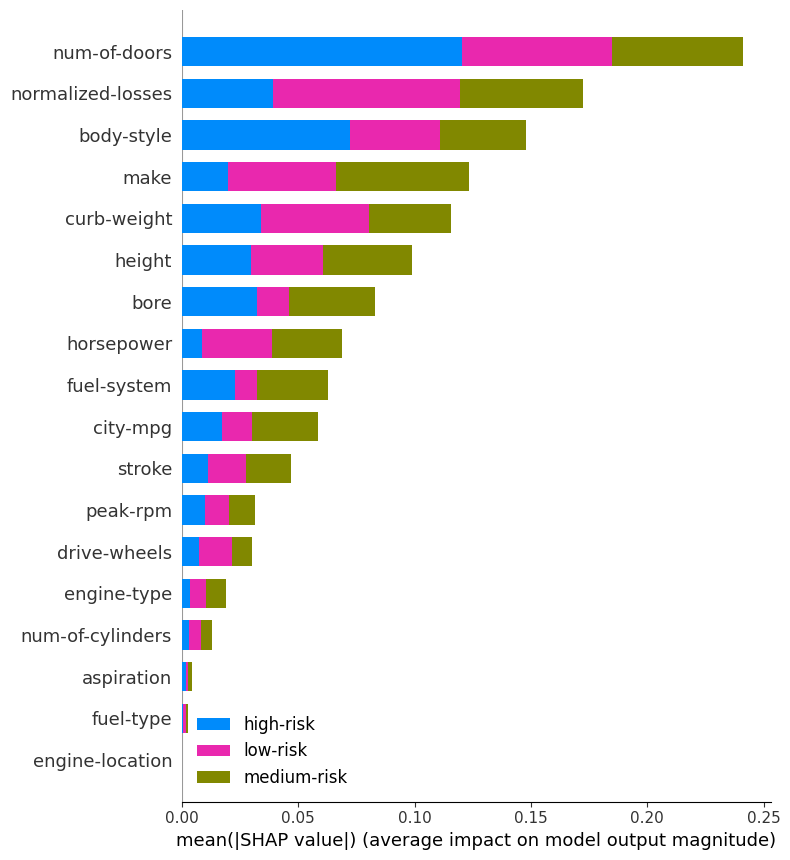

In [138]:
shap.summary_plot(shap_values_tree, X_test, class_inds="original", class_names=clf_final.classes_)
#shap.summary_plot(shap_values_tree, X_test, class_inds="original")

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. You can see that the feature pkts_sent, being the least important feature, has low Shapley values. The color represents the value of the feature from low to high. Overlapping points are jittered in the y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


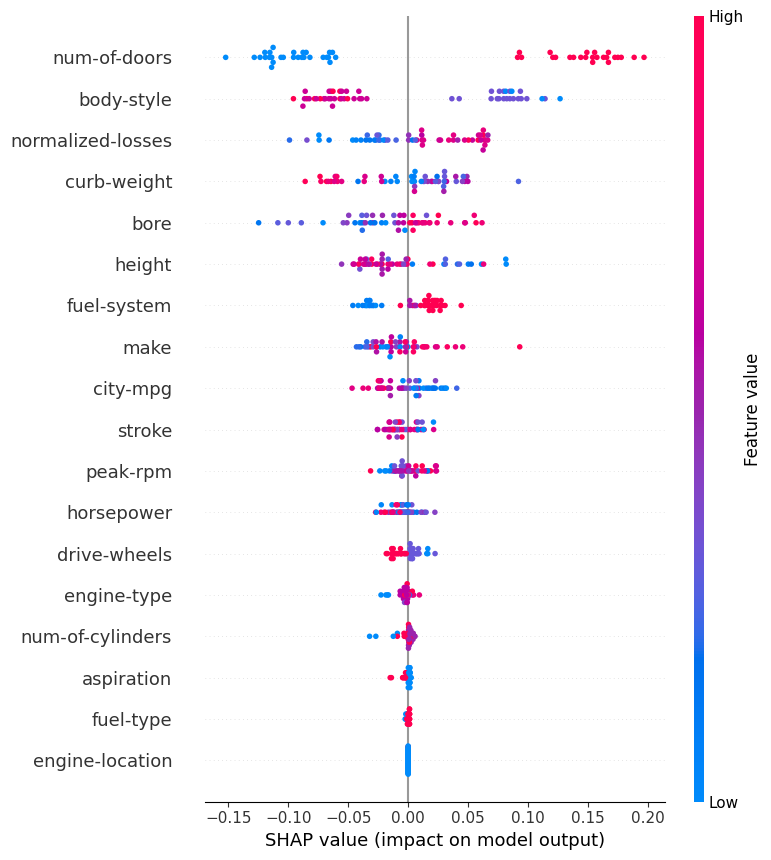

In [139]:
# Summary Plot einer bestimmten Klasse
shap.summary_plot(shap_values_tree[0], X_test)

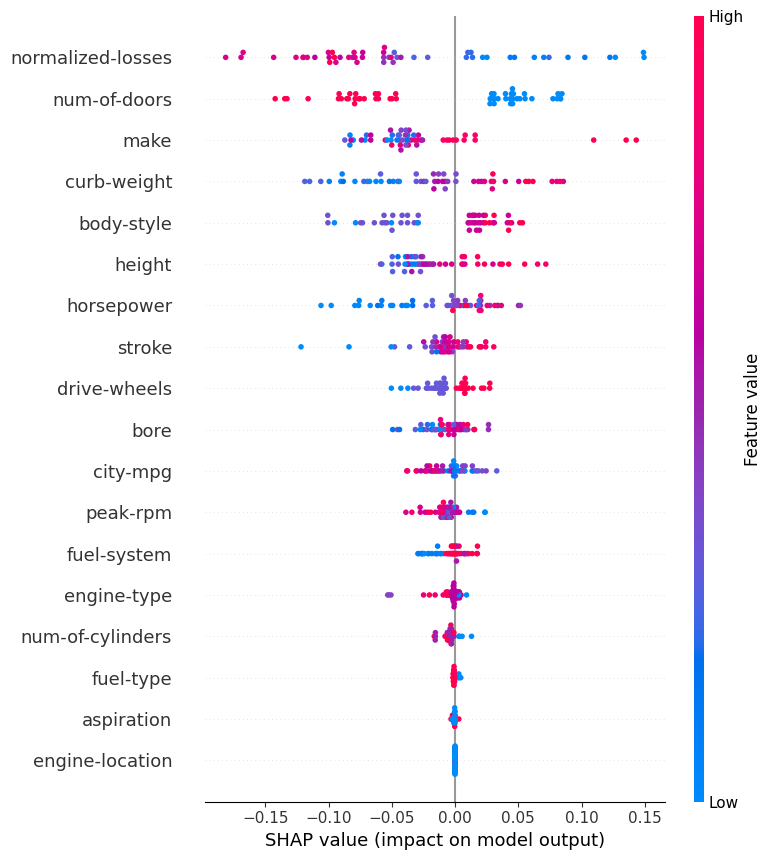

In [140]:
shap.summary_plot(shap_values_tree[1], X_test)

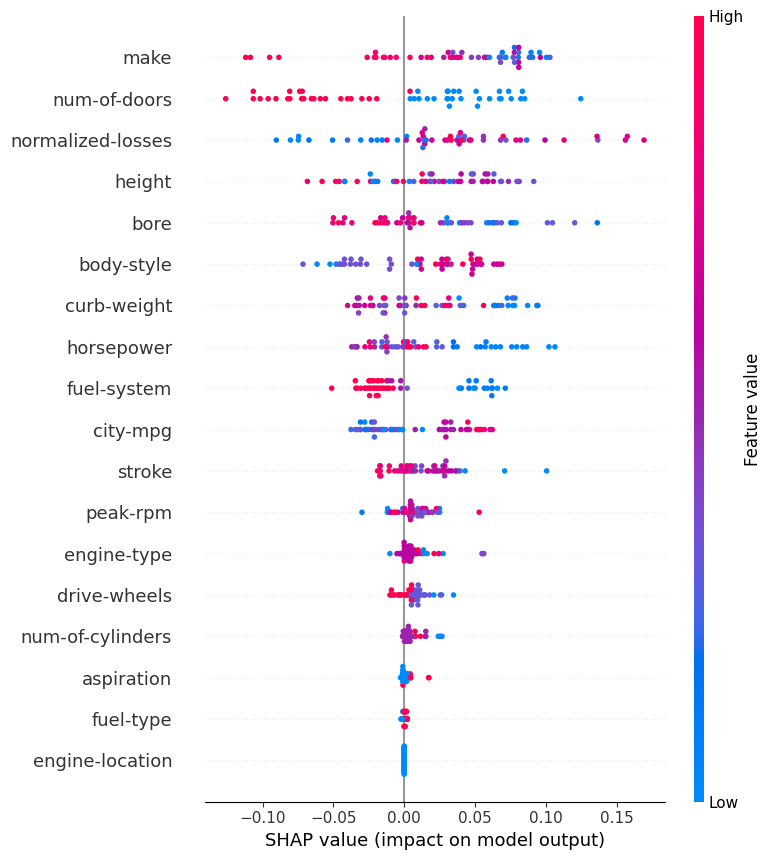

In [141]:
shap.summary_plot(shap_values_tree[2], X_test)

In [ ]:
print(len(X_test))
print(len(shap_values_tree[0]))

In [ ]:
shap.multioutput_decision_plot(explainer_tree.expected_value[0], shap_values_tree[0], X_test.iloc[0,:])

In [ ]:
print(len(X_test))
print(len(shap_values_tree[0]))

In [ ]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values_tree[0], X_test)

# Backlog

In [136]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[0], shap_values_tree[0])